# Is there evidence of a thermal gradient in the protein sequence composition of soil viral communities?

*Russell Neches*

The kinetic properties of a protein, such as its catalytic activity, half-life and solubility, depend on both the sequence of the protein and on the physical and chemical properties of its context. 


Because guanine-cytosine pairs have one more hydrogen bond than adenine-thymine pairs, sequences with higher content of G+C pairs tend to have a higher melting point. While the relationship between G+C content and temperature is weak for most genomic DNA, this is not the case for RNA genes. There is a positive relationship between the optimal growth temperature of an organism and the G+C content of its rRNA genes. <cite data-cite="2799022/2AZI7JTK"></cite>

For proteins, secondary and tertiary structures are stabilized by a wider variety of interactions among the backbone, side chains and solvent. Predicting the thermal stability of an individual protein based on its sequence alone is difficult <cite data-cite="2799022/4UI6SJBU">, </cite><cite data-cite="2799022/2C49W9X2">, </cite><cite data-cite="2799022/9LRB5D9R"></cite>. However, it is sometimes possible to predict whether the substitution of individual or a small number of residues will positively or negatively impact the stability of a protein <cite data-cite="2799022/ZX53GAQG"></cite>. Within single protein families, there may be trends of higher and lower thermal stability that can be predicted with relatively simple methods.

This is a simple approach based on rather old methods. More sophisticated methods usually rely on the availability of protein structures. This dataset consists almost entirely of novel proteins. Not only are crystal structures unavailable, but there are few (if any) crystal structures of proteins with enough sequence similarity to bootstrap computational structural models.


## Workflow

1. An all-verses-all alignment was performed with LAST <cite data-cite="2799022/WE9SX2RW"></cite>
2. Alignment summary loaded in pandas to remove self-to-self alignments <cite data-cite="2799022/5AYU4ZX7"></cite>
3. Alignment hits loaded as an undirected graph using networkx <cite data-cite="2799022/QJJW2R8F"></cite>
4. Climate data extracted from Climatic Research Unit (CRU) Time-Series (TS) version 4.01 <cite data-cite="2799022/BAVX8U9M"></cite>
5. CRU-4.01 data extracted with [`netCDF4-python`](https://github.com/Unidata/netcdf4-python)
6. Instability Index (II) <cite data-cite="2799022/32YZCZF6"></cite> calculated with `BioPython`'s ProtoParam <cite data-cite="2799022/B64GUDN5"></cite>

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import pandas
import networkx
import pyprind
import seaborn
import random
import screed
from grave import grave
import cartopy.crs
from cartopy.io.img_tiles import OSM
from netCDF4 import Dataset
from Bio.SeqUtils import ProtParam

import warnings
warnings.simplefilter( 'ignore', UserWarning )

Populating the interactive namespace from numpy and matplotlib


### Alignment

First, we perform an all-vs-all alignment using [LAST](http://last.cbrc.jp/) of
all the putative viral genes.

In [ ]:
!lastdb -P 8 -cR01 -v -p svdb soil_viruses.faa
!lastal -P32 -v -f BlastTab+ svdb soil_viruses.faa > scratch/all_v_all.tsv

The `BlastTab+` output format for LAST has the following fields, delimited by tabs :

0. query id
* subject id
* % identity
* alignment length
* mismatches
* gap opens
* q. start
* q. end
* s. start
* s. end
* evalue
* bit score
* query length
* subject length
* raw score

There is also a long header escaped by `#` characters, and the column names are weirdly separated by commas and missing the last column. So, there's no way around parsing the column names separately.

In [2]:
df = pandas.read_csv( 'scratch/all_v_all.tsv', sep='\t', header=None, comment='#' )
df.columns = [ field.strip() for field in open( 'scratch/all_v_all.tsv' ).readlines()[35][10:].split(',') ] + ['raw score']
df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,raw score
0,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,100.00,160,0,0,1,160,1,160,6.200000e-126,397.0,160,160,892
1,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300002243_____C687J29039_10000481_____C687J29...,74.17,151,38,1,1,150,297,447,1.700000e-81,271.0,160,456,606
2,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300014493_____Ga0182016_10005848_____Ga018201...,51.11,135,64,2,14,148,275,407,2.200000e-39,150.0,160,413,333
3,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300006638_____Ga0075522_10000183_____Ga007552...,43.88,139,77,1,9,147,261,398,3.500000e-36,141.0,160,431,312
4,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300001160_____JGI12654J13325_1000002_____JGI1...,47.06,136,71,1,9,144,267,401,8.200000e-35,137.0,160,411,303


In [3]:
# drop self-to-self alignments

df = df.where( df['subject id'] != df['query id'] ).dropna()

In [4]:
# checkpoint

df[ ['subject id', 'query id', 'bit score'] ].to_csv( 'scratch/all_v_all.abc', sep='\t', header=None )

### Alignment graph construction

Now that table of alignment summaries is ready, let's treat each alignment as an edge in an undirected graph. This has the (desirable) side effect of collapsing A-to-B and B-to-A alignments into a single edge. We'll use the LAST bit score of each alignment as the edge weight.

In [5]:
G = networkx.Graph()
G.add_nodes_from( set( df['query id'] ) | set( df['subject id'] ) )

progbar = pyprind.ProgBar( df.shape[0], title='adding graph edges...' )

for n,row in df.iterrows() :
    progbar.update()
    G.add_edge( row['subject id'], row['query id'], weight=row['bit score'] )

adding graph edges...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:19:11


### Connected component extraction

Next, we decompose the alignment graph into its connected components. These are
our putative viral protein families.

In [7]:
# get the adjacency matrix in sparse form
aj = networkx.to_scipy_sparse_matrix(G)

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

Let's have a look at the distribution of subgraph sizes. At the big end of the distribution, 
we have one massive hairball, followed by several more reasonably-sized chunks.

In [13]:
[ len(g) for g in components[0:10] ]

[210085, 2155, 1235, 799, 699, 644, 624, 591, 561, 550]

[]

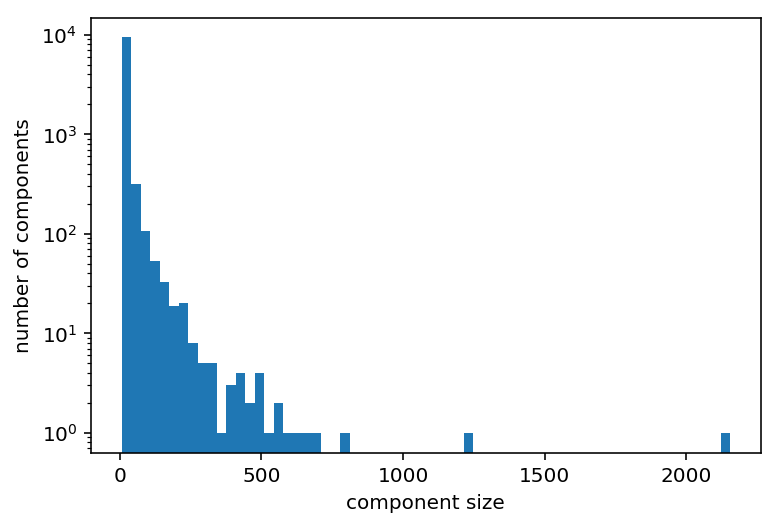

In [21]:
hist( [ len(g) for g in components[1:10000] ], 64 )
xlabel( 'component size' )
ylabel( 'number of components' )
semilogy()

### Index and load protein sequence data

Some of our putative viral proteins do not align with anything else in the dataset, so
they're not present in the graph. So, let's index and load the sequence data.

In [34]:
import screed

screed.make_db( 'data/soil_viruses.faa' )
viralgenes = screed.ScreedDB( 'data/soil_viruses.faa' )

In [48]:
print( 'total viral genes :', len( set( viralgenes.keys() ) ) )
print( 'genes with hits   :', len( set( G.nodes ) ) )
print( 'singleton genes   :', len( set( viralgenes.keys() ) - set( G.nodes ) ) )
print( 'doublet genes     :', sum( len(g) == 2 for g in components ) )
print( 'triplet genes     :', sum( len(g) == 3 for g in components ) )
print( 'quartet or less   :', sum( len(g) <= 4 for g in components ) )

total viral genes : 878927
genes with hits   : 633995
singleton genes   : 244932
doublet genes     : 58728
triplet genes     : 19636
quartet or less   : 88227


24% of the genes are in the giant hairball.

At the other end of the subgraph size distribution, we find a relatively short tail. 72% 
of genes align to at least one other gene, and 28% are singletons. 10% of genes fall into
components of four members or fewer.

Let's have a closer look at the medium-sized components. Here, I've made network plots
of 16 components, starting with the 300th to the 316th largest.

Node size represents the [closeness centrality](https://en.wikipedia.org/wiki/Closeness_centrality),
scaled to the maximum centrality (smaller nodes have a higher closeness). Edges are colored by the
bit score of the alignment.

### Plot putative viral protein family networks

First, let's take a look at the distribution of bit scores so we know how
to scale the edge weightings.

In [81]:
bit_min = min( df['bit score'] )
bit_max = max( df['bit score'] )
bit_med = median( df['bit score'] )

pandas.DataFrame.describe( df['bit score'] )

count    6.770267e+06
mean     2.821097e+02
std      2.904721e+02
min      4.740000e+01
25%      1.130000e+02
50%      1.950000e+02
75%      3.450000e+02
max      1.670000e+04
Name: bit score, dtype: float64

[]

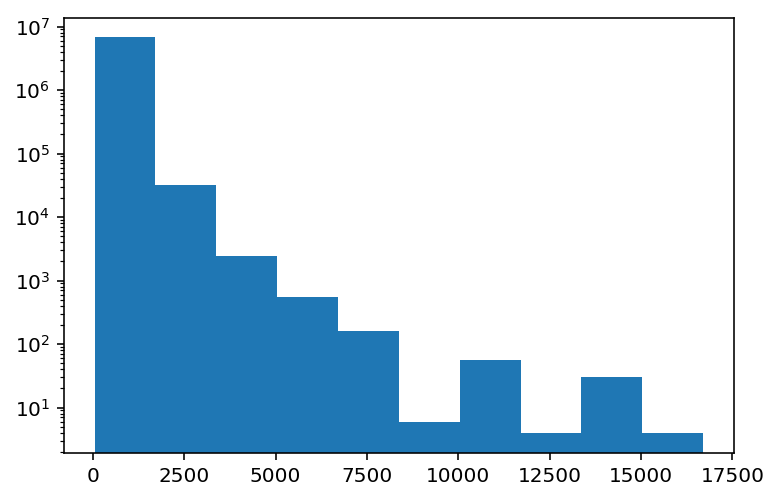

In [148]:
hist( df['bit score'] )
semilogy()

That's an obnoxious distribution, but most protein families fall somewhere below the median
bit score. So, we'll just scale to the median for the purposes of plotting the edge weights.

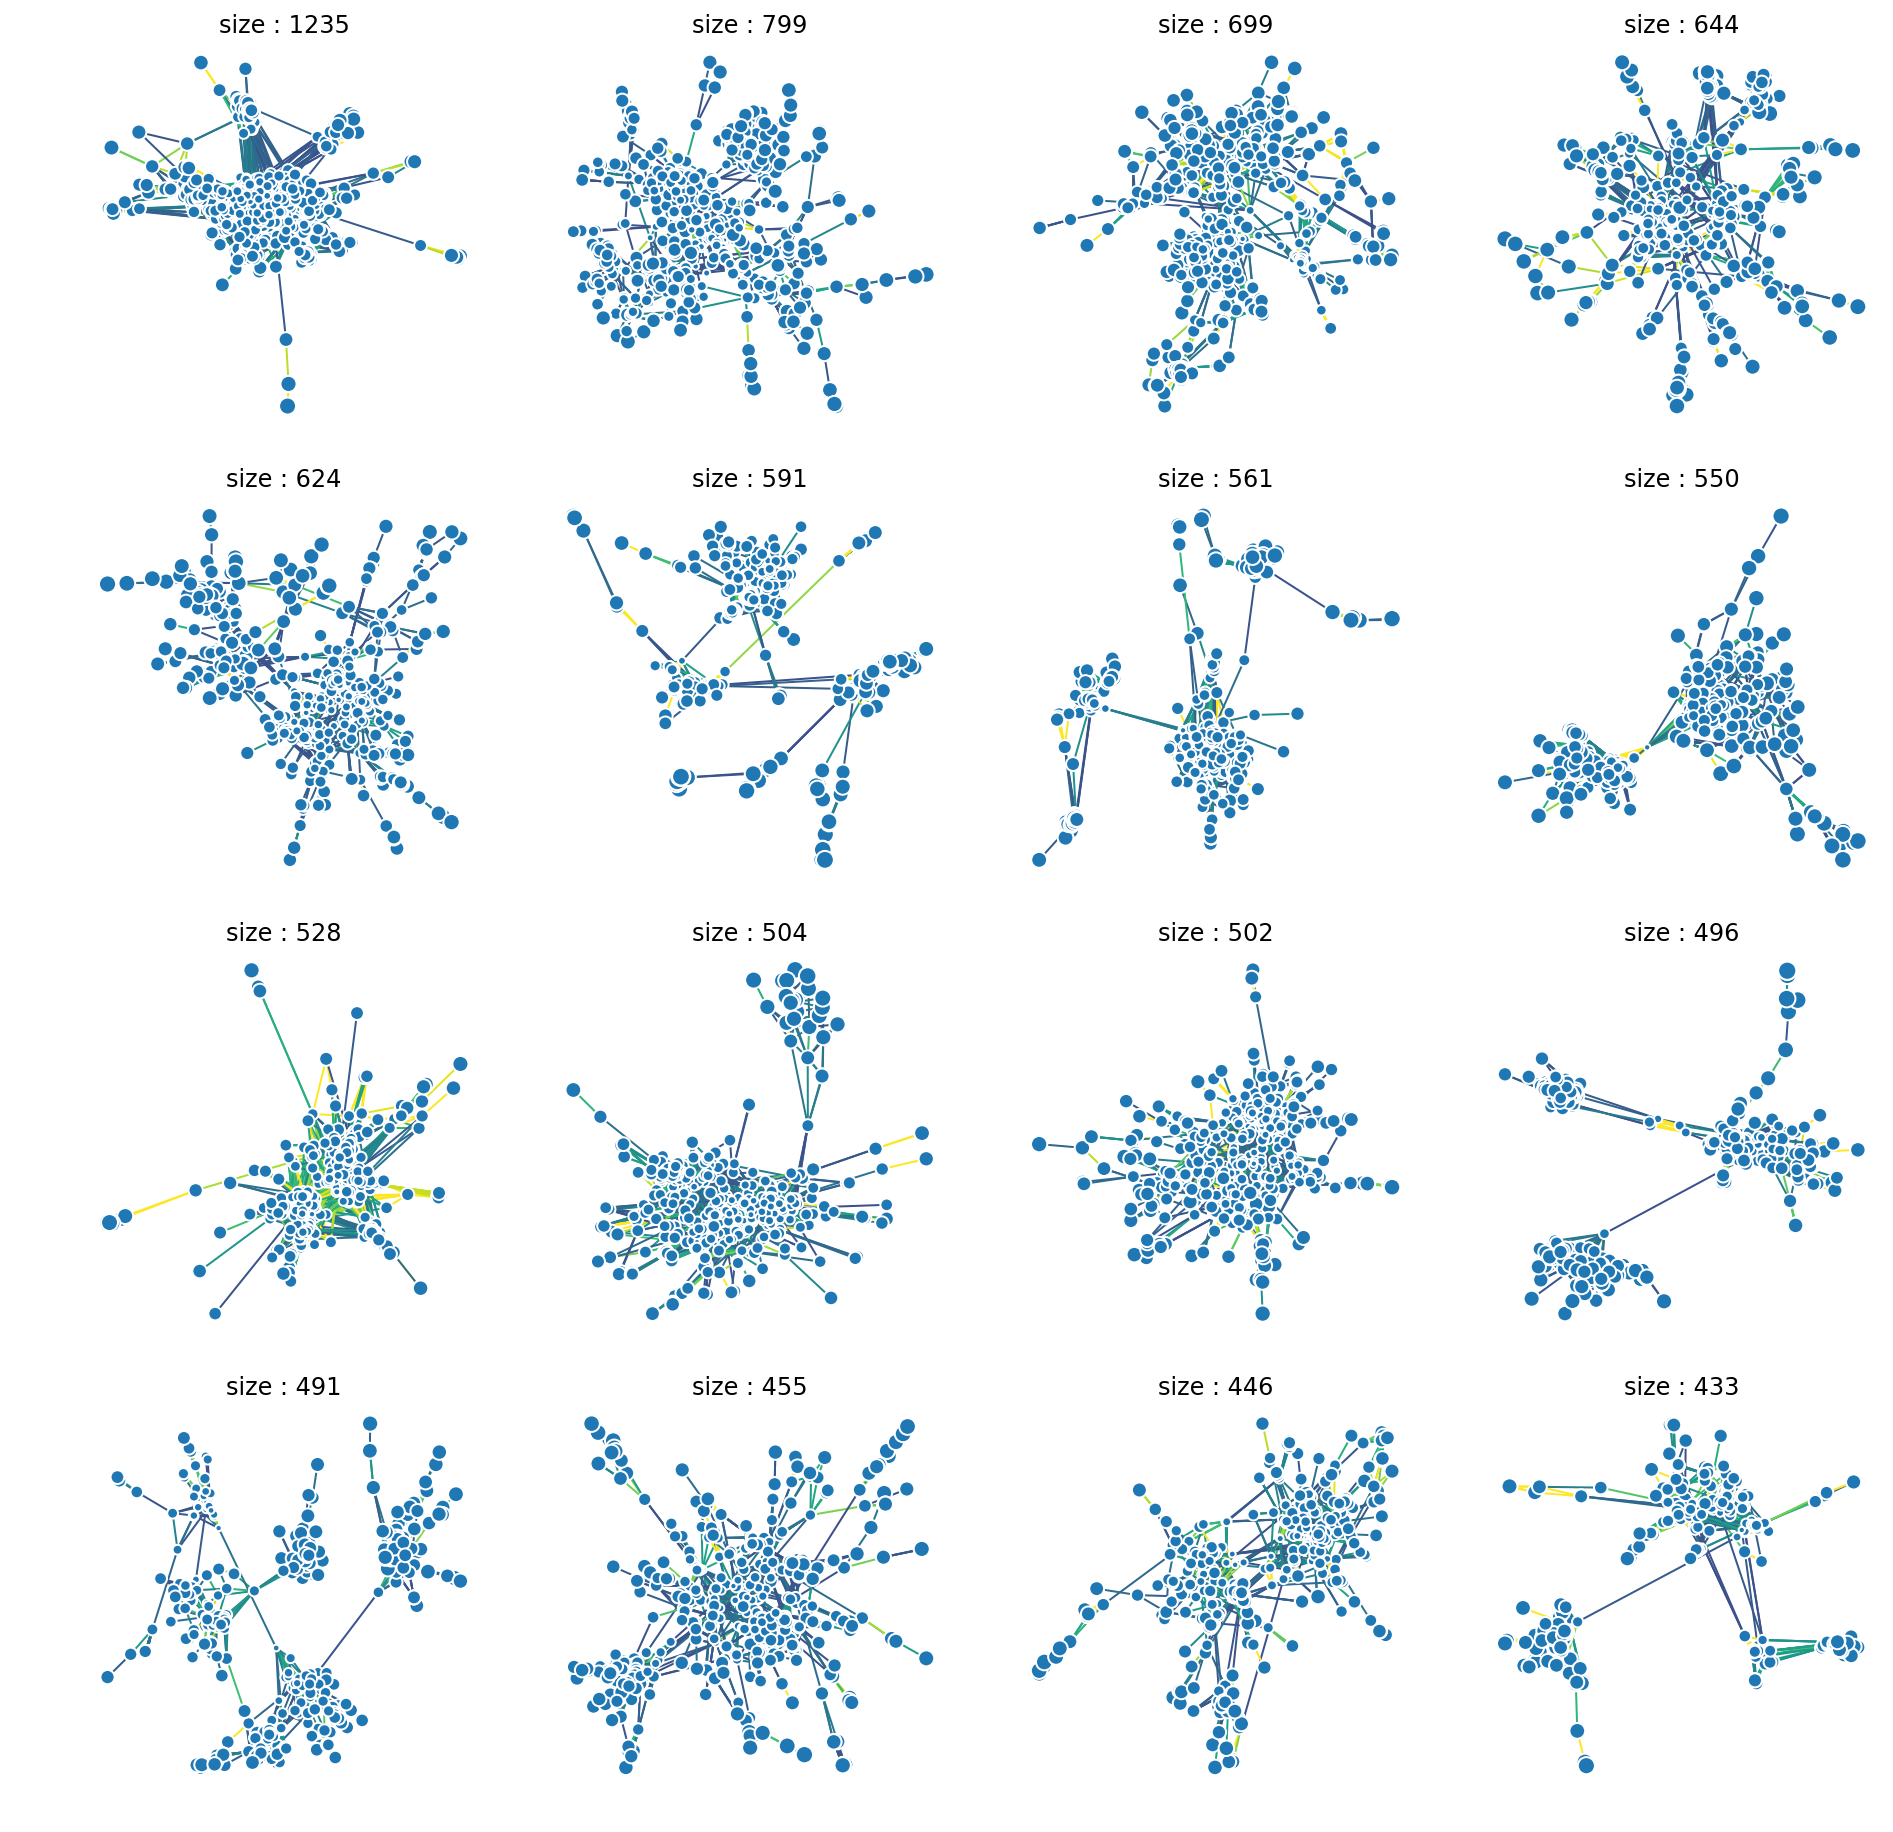

In [361]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'weight', 1 ) }

for n,g in enumerate(components[ 2:18 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( 1 - ( centrality[node] /
                                    max_centrality) + .1 ) * 100
    
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( edge_attributes['weight'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

In [222]:
# generate FASTA files for individual protein families
# (useful for examining multiple sequence alignments)
with open( '/tmp/foo.fa', 'w' ) as f :
    for n,node in enumerate( components[300].nodes ) :
        f.write( '> ' + str(n) + '\n' + str(viralgenes[node].sequence) + '\n' )

In [208]:
# generate a FASTA file from a random sampling of genes from the giant hairball
sampled_nodes = [ random.choice( list( components[0].nodes() ) ) for i in range(256) ]
with open( '/tmp/foo.fa', 'w' ) as f :
    for n,node in enumerate( sampled_nodes ) :
        f.write( '> ' + str(n) + '\n' + str(viralgenes[node].sequence) + '\n' )

### Load sample and mVC metadata

The metadata table contains some mVC's (metagenomic viral contigs, or putative viral genomes)
that we don't actually want because they come from samples that are not soil. So, we need to
remove them from the table before we continue.

In [351]:
metadata = pandas.read_csv( 'data/metadata.csv', sep=',', index_col=0, low_memory=False )

print( 'total records :', metadata.shape[0] )

filtered_mVCs = []
for line in open( 'data/soil_contigs.txt' ).readlines() :
    filtered_mVCs.append( line.replace( '.a:', '_____' ).strip() )
    
print( 'records to drop :', len( set( metadata.index ) ^ set( filtered_mVCs ) ) )

metadata = metadata.drop( set( metadata.index ) ^ set( filtered_mVCs ), axis=0 )
print( 'records retained :', metadata.shape[0] )

total records : 36384
records to drop : 12050
records retained : 24334


### Extract sample geolocations

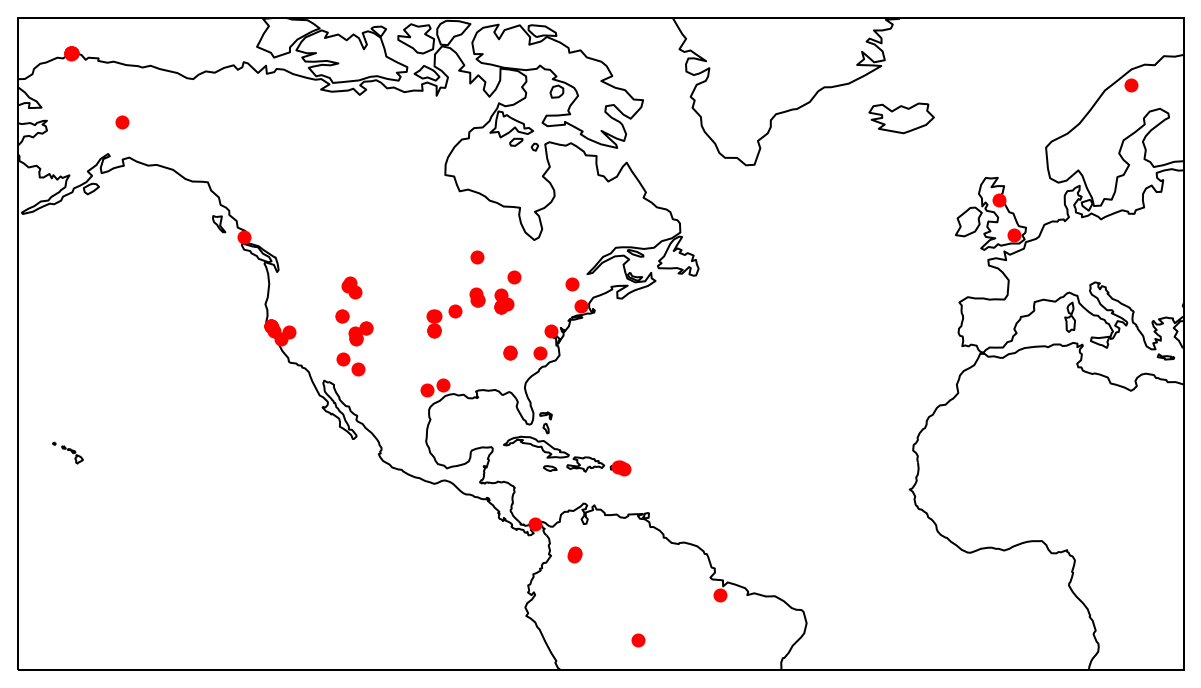

In [159]:
figure( figsize=(12,6) )

# this is kinda horrible, but whatever
locstrings = set( ','.join( (str(a),str(b)) ) for a,b in zip( list( metadata.Latitude ), 
                                                              list( metadata.Longitude ) ) ) 

locations = []
for locstring in locstrings :
    lat, lon = locstring.split(',')
    if lat == 'nan' : continue
    locations.append( ( float(lat), float(lon) ) )

ax = plt.axes( projection=cartopy.crs.Miller() )
#ax.add_image( GoogleTiles( style='satellite' ), 3 )
ax.coastlines()

y, x = zip(*locations)
plot( x, y, 'ro', transform=cartopy.crs.Geodetic() )

### Extract climate data

We'd like to know the typical temperatures in the locations where the samples were 
collected. For this, we average the last ten years of observations from the 
[CRU-TS-4.01](http://data.ceda.ac.uk/badc/cru/data/cru_ts/cru_ts_4.01/) dataset.

Text(0,0.5,'degrees C$^\\circ$')

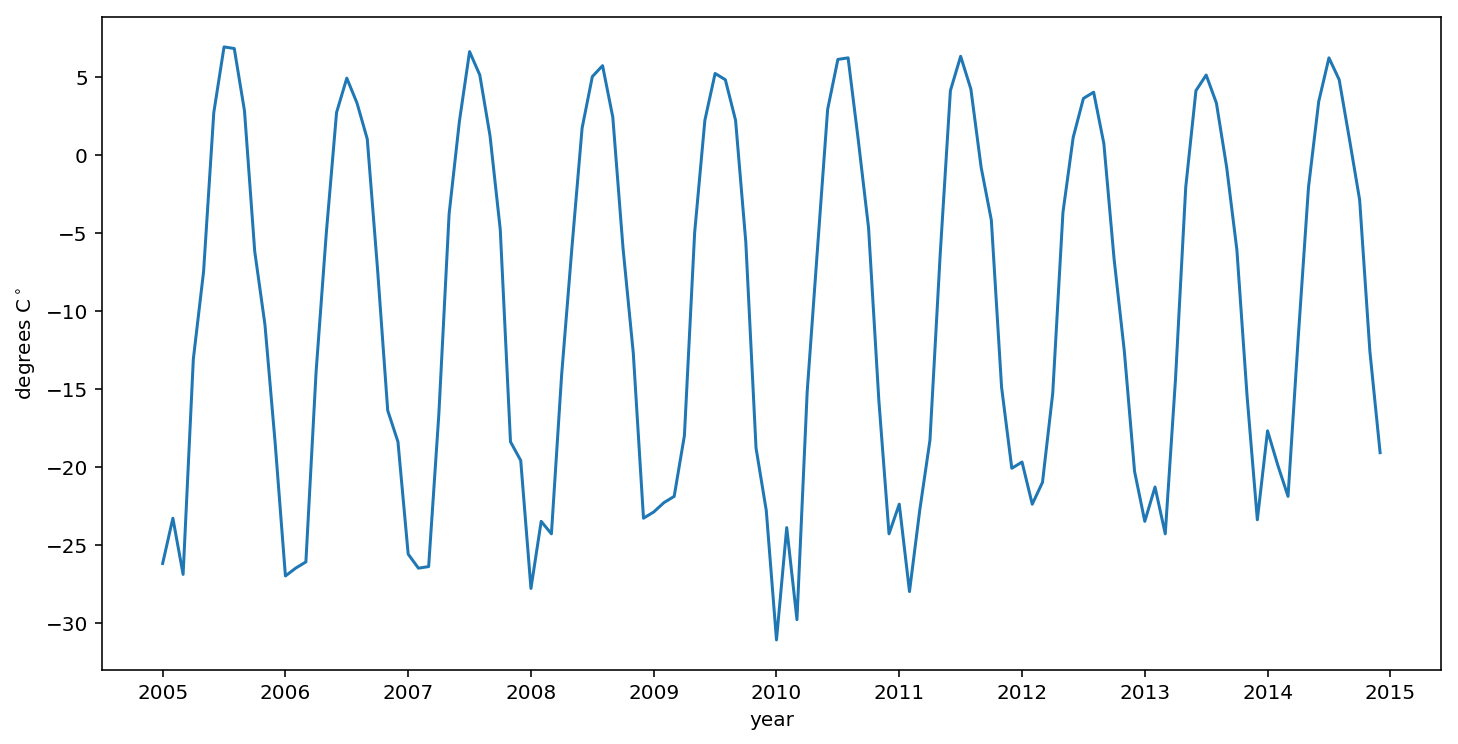

In [327]:
from netCDF4 import Dataset

nc = Dataset( '../../data/cru_ts4.01.1901.2016.tmp.dat.nc', 'r' )

figure( figsize=(12,6) )

# find the closest grid square for the first sample
lat_index = abs( nc.variables['lat'][:] - locations[0][0] ).argmin()
lon_index = abs( nc.variables['lon'][:] - locations[0][1] ).argmin()

plot( nc.variables['tmp'][-120:,lat_index,lon_index] )
xticks( list(range( 0, 130, 12 )), range(2005,2016) )
xlabel( 'year' )
ylabel( r'degrees C$^\circ$' )

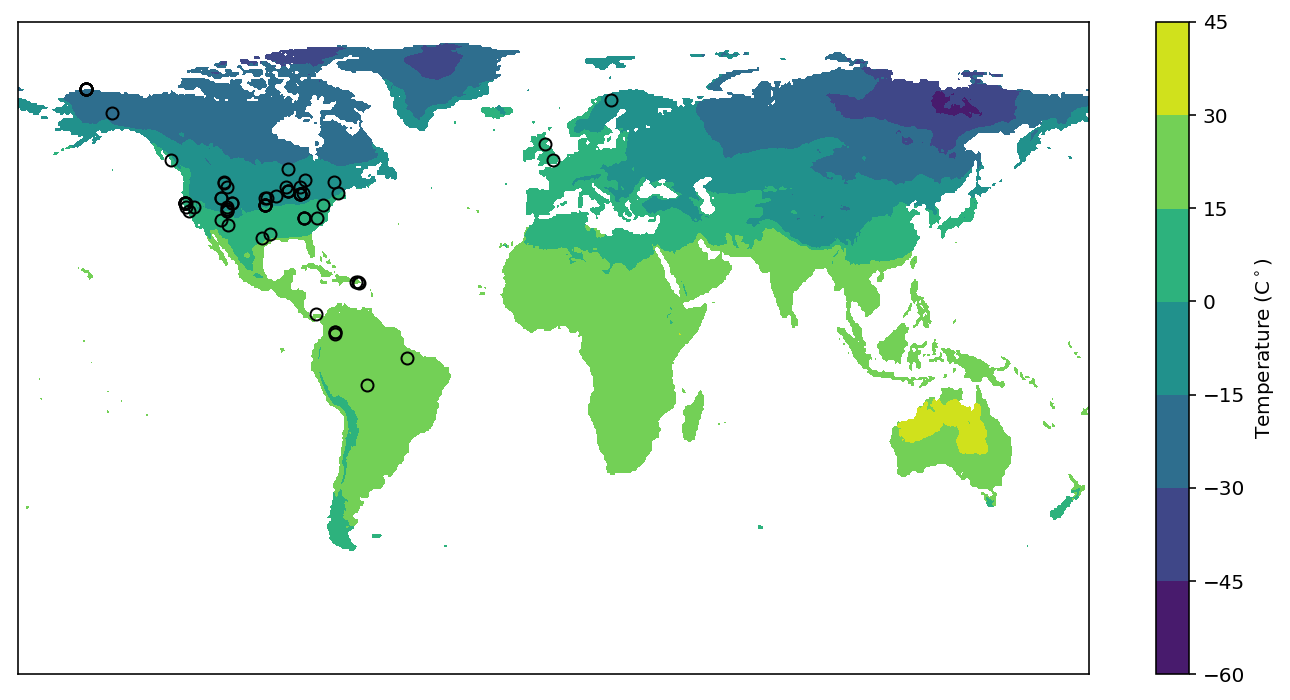

In [315]:
figure( figsize=(12,6) )

contourf( nc.variables['tmp'][-1,:,:] )

temps = []
for lat,lon in locations :
    # find the closest grid square
    lat_index = abs( nc.variables['lat'][:] - lat ).argmin()
    lon_index = abs( nc.variables['lon'][:] - lon ).argmin()
    plot( lon_index, lat_index, marker='o', color='black', fillstyle='none' )
    temps.append( mean( nc.variables['tmp'][-120:,lat_index,lon_index] ) )
xticks([])
yticks([])
colorbar( label=r'Temperature (C$^\circ$)' )

In [316]:
L = pandas.DataFrame( locations, columns=[ 'Latitude', 'Longitude' ] )
L[ 'Temperature' ] = temps
L.head()

,Latitude,Longitude,Temperature
0,71.2999,-156.6100,-9.96917
1,39.2140,-96.5852,13.25
2,44.0647,-85.3817,7.18917
3,37.9013,-109.5337,8.56083
4,35.9000,-79.0500,15.68


### Calculate instability index

The  Instability Index from [`ProtoParam`](https://web.expasy.org/protparam/protparam-doc.html) is not
the most sophisticated way to estimate the thermal stability of a protein. However, because it relies only on
dipeptide frequencies, it doesn't require knowledge of the tertiary structure. This is useful for us because
many of the proteins in this dataset belong to novel protein families, and have no known crystal structure.

Text(-12.8886,37,'stable')

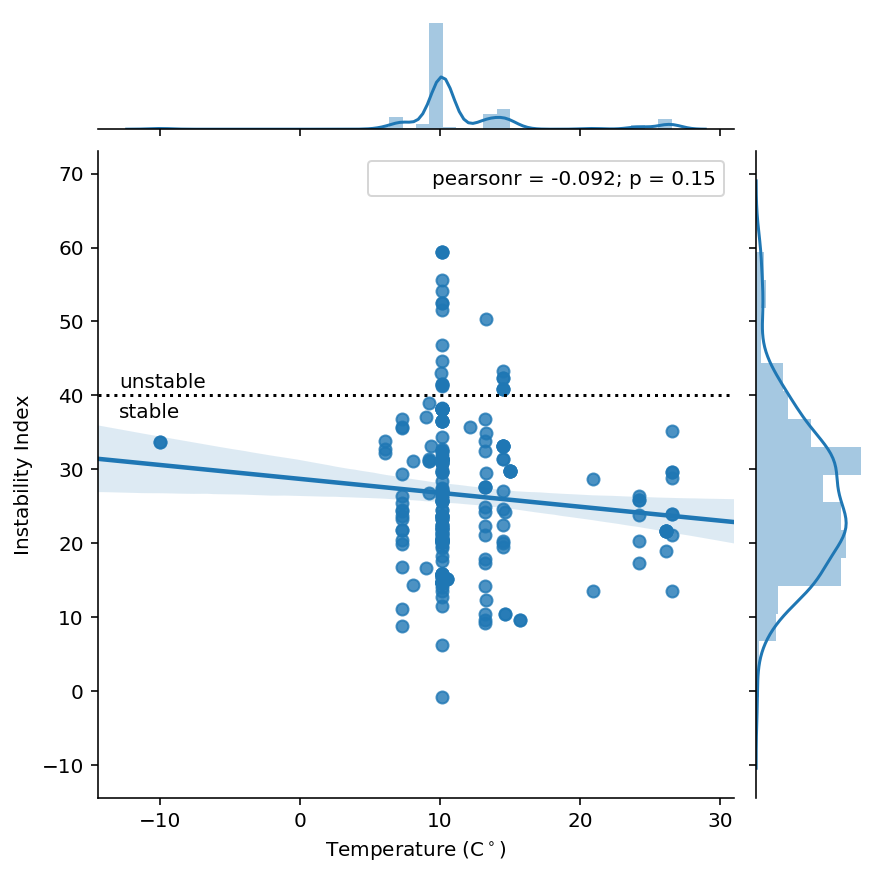

In [359]:
from Bio.SeqUtils import ProtParam

tmp, ii, iop, gravy = [],[],[],[]
for node in components[40].nodes :
    seq = str( viralgenes[node].sequence ).replace('*','')
    
    # if a stop codon appears in the sequence, truncate the 
    # sequence to the first stop codon unless the stop codon 
    # appears in the first 90% of the sequence
    if seq.__contains__('X') :
        S = seq.split( 'X' )
        if len( S[0] ) / len( seq ) > 0.9 :
            seq = S[0]
        else :
            continue
        
    X = ProtParam.ProteinAnalysis( seq )
    mVC = '_____'.join( node.split('_____')[:2] )
    #if mVC in metadata.index : continue
    lat = metadata.loc[ mVC ].Latitude
    lon = metadata.loc[ mVC ].Longitude
    if isnan(lat) or isnan(lon) : continue
    # this is inefficient, but it works :-/
    tmp.append( float( L.where( ( L.Latitude == lat ) & ( L.Longitude == lon ) ).dropna().Temperature ) )
    ii.append( X.instability_index() )
    iop.append( X.isoelectric_point() )
    gravy.append( X.gravy() )
    
seaborn.jointplot( array(tmp), array(ii), kind='reg' )
xlabel( r'Temperature (C$^\circ$)' )
ylabel( 'Instability Index' )

axhline( 40, ls=':', color='black' )
text( min(tmp) - 0.08*( max(tmp) - min(tmp) ), 41, 'unstable' )
text( min(tmp) - 0.08*( max(tmp) - min(tmp) ), 37, 'stable' )

Proteins with an Instability Index below 40 are predicted to be stable under standard conditions.
If ambient temperature has a significant impact on the function of a protein family, we would expect
a negative correlation between the Instability Index and the average ambient temperature.

In [325]:
def tmp_dependence( component ) :
    tmp, ii = [],[]
    for node in component.nodes :
        seq = str( viralgenes[node].sequence ).replace('*','')
        
        # if a stop codon appears in the sequence, truncate the 
        # sequence to the first stop codon unless the stop codon 
        # appears in the first 90% of the sequence
        if seq.__contains__('X') :
            S = seq.split( 'X' )
            if len( S[0] ) / len( seq ) > 0.9 :
                seq = S[0]
            else :
                continue
        
        X = ProtParam.ProteinAnalysis( seq )
        mVC = '_____'.join( node.split('_____')[:2] )
        lat = metadata.loc[ mVC ].Latitude
        lon = metadata.loc[ mVC ].Longitude
        if isnan(lat) or isnan(lon) : continue
        # this is inefficient, but it works :-/
        tmp.append( float( L.where( ( L.Latitude == lat ) & ( L.Longitude == lon ) ).dropna().Temperature ) )
        ii.append( X.instability_index() )
    return tmp, ii

In [326]:
progbar = pyprind.ProgBar( 1000, title='computing instability indexes for protein families...' )

tmp_dep_components = []
for i in range( 1, 1001 ) : # skip the giant hairball
    progbar.update()
    tmp_dep_components.append( tmp_dependence( components[i] ) )

computing instability indexes for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:33:11


In [353]:
from scipy.stats import pearsonr, kendalltau

tmp_corr = [ kendalltau(tmp,ii) for tmp,ii in tmp_dep_components ]
taus = array( [ tau.correlation for tau in tmp_corr ] )

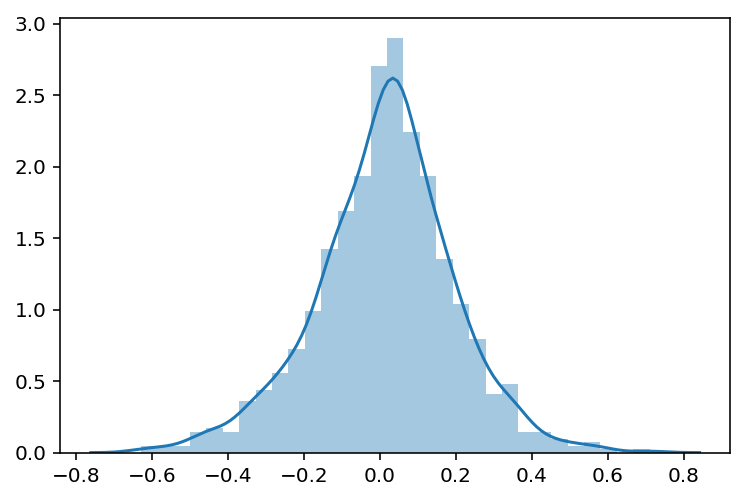

In [360]:
seaborn.distplot( taus[~isnan(taus)] )

# References

<div class="cite2c-biblio"></div>